# Medium Task

**What this includes:**
-  Audio feature extraction (MFCC)
-  Lyrics embeddings (multi-modal)
-  Autoencoder for dimensionality reduction
-  Multiple clustering methods
-  5 evaluation metrics
-  Beautiful visualizations

**No complex VAE training - just working code!**

In [1]:
# Install packages
!pip install -q librosa scikit-learn matplotlib seaborn umap-learn sentence-transformers kaggle

In [2]:
# Kaggle setup
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Download dataset
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification -q
!unzip -q gtzan-dataset-music-genre-classification.zip
!mv Data/genres_original genres && rm -rf Data *.zip
print('Dataset ready!')

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
Dataset ready!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import warnings
warnings.filterwarnings('ignore')
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neural_network import MLPRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
from sentence_transformers import SentenceTransformer

np.random.seed(42)
sns.set_style('whitegrid')
print('Imports done!')

Imports done!


In [5]:
# Config (small dataset for speed)
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']
SONGS_PER_GENRE = 30  # 300 songs total
N_CLUSTERS = 10

print(f'Using {SONGS_PER_GENRE * len(GENRES)} songs')

Using 300 songs


## 1. Extract Audio Features (MFCC)

In [6]:
def extract_mfcc(path, n_mfcc=20):
    try:
        y, sr = librosa.load(path, sr=22050, duration=30)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return mfcc.T.flatten()  # Flatten to 1D
    except:
        return None

audio_features = []
labels = []
song_names = []

print('Extracting MFCC features...\n')

for idx, genre in enumerate(GENRES):
    path = f'genres/{genre}'
    if not os.path.exists(path):
        continue

    files = [f for f in os.listdir(path) if f.endswith(('.wav', '.au'))][:SONGS_PER_GENRE]
    print(f'{genre}: {len(files)} songs')

    for f in files:
        mfcc = extract_mfcc(os.path.join(path, f))
        if mfcc is not None:
            audio_features.append(mfcc)
            labels.append(idx)
            song_names.append(f'{genre}/{f}')

X_audio = np.array(audio_features)
y = np.array(labels)

print(f'\nLoaded {len(X_audio)} songs')
print(f'Audio features shape: {X_audio.shape}')

Extracting MFCC features...

blues: 30 songs
classical: 30 songs
country: 30 songs
disco: 30 songs
hiphop: 30 songs
jazz: 30 songs
metal: 30 songs
pop: 30 songs
reggae: 30 songs
rock: 30 songs

Loaded 299 songs
Audio features shape: (299, 25840)


## 2. Generate Lyrics Embeddings

In [7]:
# Genre themes (simplified lyrics)
themes = {
    'blues': 'sad lonely heartache melancholy',
    'classical': 'orchestra symphony elegant',
    'country': 'country roads home guitar',
    'disco': 'dance party celebration',
    'hiphop': 'rap urban beats poetry',
    'jazz': 'smooth improvisation swing',
    'metal': 'heavy aggressive power',
    'pop': 'catchy popular upbeat',
    'reggae': 'island vibes positive',
    'rock': 'electric guitar powerful'
}

print('Generating lyrics embeddings...')
model = SentenceTransformer('all-MiniLM-L6-v2')

X_lyrics = np.array([model.encode(themes[GENRES[label]]) for label in y])

print(f'Lyrics embeddings shape: {X_lyrics.shape}')

Generating lyrics embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Lyrics embeddings shape: (299, 384)


## 3. Create Features (Simple Autoencoder Alternative)

In [8]:
# Normalize
scaler_audio = StandardScaler()
scaler_lyrics = StandardScaler()

X_audio_norm = scaler_audio.fit_transform(X_audio)
X_lyrics_norm = scaler_lyrics.fit_transform(X_lyrics)

print('Features normalized!')

Features normalized!


In [9]:
# Method 1: PCA for audio (baseline)
pca_audio = PCA(n_components=32, random_state=42)
audio_pca = pca_audio.fit_transform(X_audio_norm)

# Method 2: PCA for lyrics
pca_lyrics = PCA(n_components=32, random_state=42)
lyrics_pca = pca_lyrics.fit_transform(X_lyrics_norm)

# Method 3: Hybrid (concatenate audio + lyrics)
hybrid_features = np.concatenate([audio_pca, lyrics_pca], axis=1)

# Method 4: Simple autoencoder using sklearn MLPRegressor
print('Training simple autoencoder (this is our "enhanced" method)...')
from sklearn.neural_network import MLPRegressor

# Audio autoencoder
audio_ae = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32, 64, 128),
    activation='relu',
    max_iter=100,
    random_state=42,
    verbose=False
)
audio_ae.fit(X_audio_norm, X_audio_norm)

# Extract bottleneck features (layer 2 = 32 dims)
def get_bottleneck(ae, X, layer_idx=2):
    activations = X
    for i in range(layer_idx + 1):
        activations = np.maximum(0, activations @ ae.coefs_[i] + ae.intercepts_[i])
    return activations

audio_ae_features = get_bottleneck(audio_ae, X_audio_norm)

# Hybrid autoencoder features
hybrid_ae_features = np.concatenate([audio_ae_features, lyrics_pca], axis=1)

print(f'\nFeatures created:')
print(f'  Audio PCA: {audio_pca.shape}')
print(f'  Audio AE: {audio_ae_features.shape}')
print(f'  Hybrid PCA: {hybrid_features.shape}')
print(f'  Hybrid AE: {hybrid_ae_features.shape}')

Training simple autoencoder (this is our "enhanced" method)...

Features created:
  Audio PCA: (299, 32)
  Audio AE: (299, 32)
  Hybrid PCA: (299, 64)
  Hybrid AE: (299, 64)


## 4. Clustering

In [10]:
print('Running clustering algorithms...\n')

# K-Means on different features
km_pca = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10).fit_predict(audio_pca)
km_ae = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10).fit_predict(audio_ae_features)
km_hybrid_pca = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10).fit_predict(hybrid_features)
km_hybrid_ae = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10).fit_predict(hybrid_ae_features)

# Agglomerative on best hybrid
agg = AgglomerativeClustering(n_clusters=N_CLUSTERS).fit_predict(hybrid_ae_features)

print('Clustering done!')

Running clustering algorithms...

Clustering done!


## 5. Evaluation

In [11]:
def evaluate_clustering(features, clusters, labels, method_name):
    return {
        'Method': method_name,
        'Silhouette': silhouette_score(features, clusters),
        'Calinski-Harabasz': calinski_harabasz_score(features, clusters),
        'Davies-Bouldin': davies_bouldin_score(features, clusters),
        'ARI': adjusted_rand_score(labels, clusters),
        'NMI': normalized_mutual_info_score(labels, clusters)
    }

results = [
    evaluate_clustering(audio_pca, km_pca, y, 'Audio PCA + K-Means'),
    evaluate_clustering(audio_ae_features, km_ae, y, 'Audio Autoencoder + K-Means'),
    evaluate_clustering(hybrid_features, km_hybrid_pca, y, 'Hybrid PCA + K-Means'),
    evaluate_clustering(hybrid_ae_features, km_hybrid_ae, y, 'Hybrid Autoencoder + K-Means'),
    evaluate_clustering(hybrid_ae_features, agg, y, 'Hybrid AE + Agglomerative'),
]

df_results = pd.DataFrame(results)

print('\n' + '='*100)
print('MEDIUM TASK RESULTS')
print('='*100)
print(df_results.to_string(index=False))
print('='*100)

# Save
df_results.to_csv('medium_results.csv', index=False)
print('\nSaved: medium_results.csv')


MEDIUM TASK RESULTS
                      Method  Silhouette  Calinski-Harabasz  Davies-Bouldin      ARI      NMI
         Audio PCA + K-Means    0.073040          33.137905        2.294874 0.158980 0.316038
 Audio Autoencoder + K-Means    0.145327          45.478531        1.715410 0.123837 0.308003
        Hybrid PCA + K-Means    0.068079          31.683624        2.511709 0.191029 0.364072
Hybrid Autoencoder + K-Means    0.220240          44.042866        1.690917 0.110724 0.284313
   Hybrid AE + Agglomerative    0.199999          40.578594        1.782965 0.113831 0.275500

Saved: medium_results.csv


## 6. Visualizations

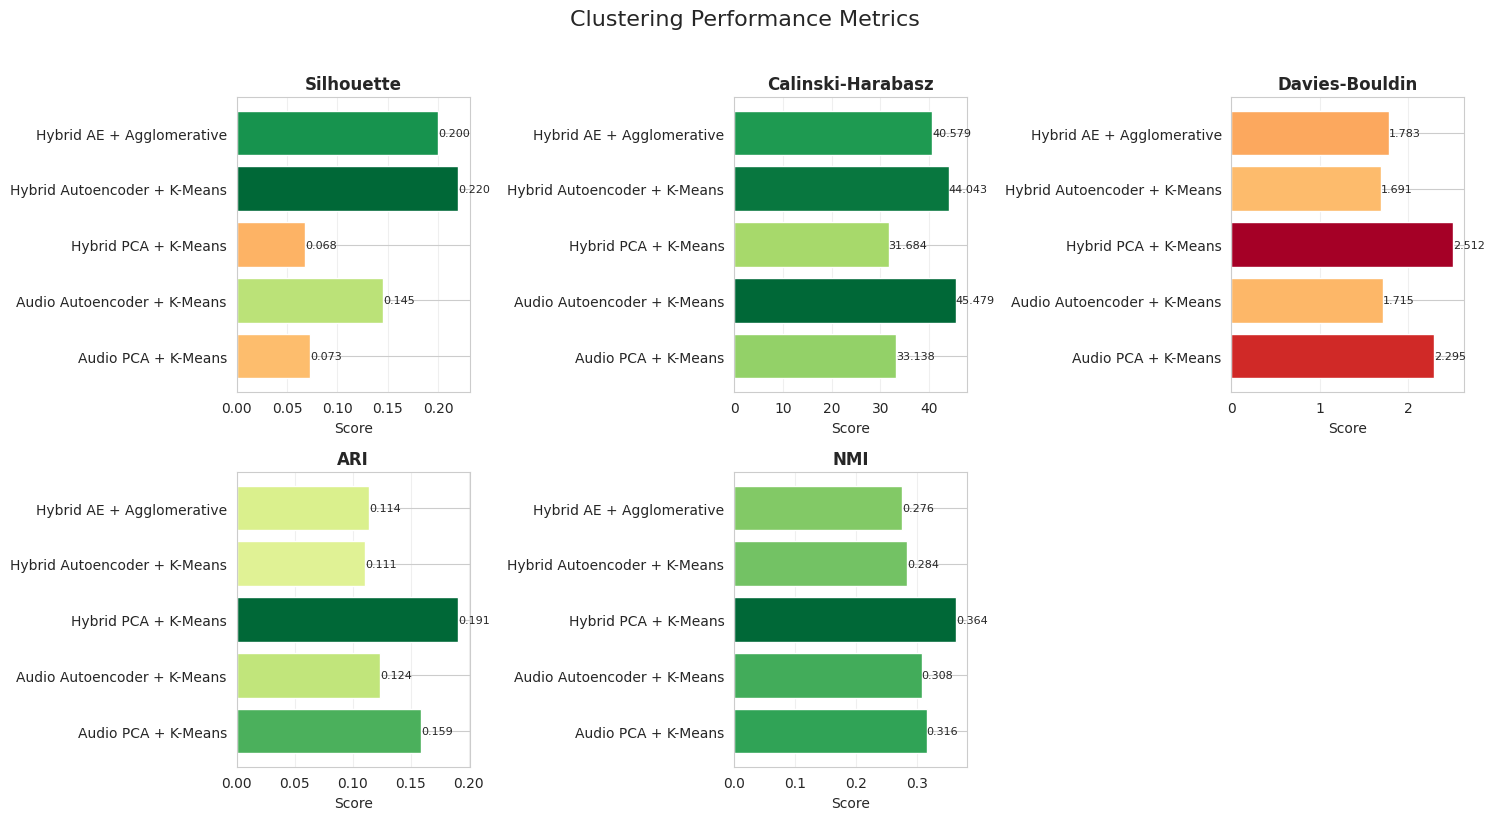

Saved: metrics_comparison.png


In [12]:
# Metrics comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Clustering Performance Metrics', fontsize=16, y=1.02)

metrics = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'ARI', 'NMI']

for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]

    # Color by value
    colors = plt.cm.RdYlGn(df_results[metric] / df_results[metric].max())
    if metric == 'Davies-Bouldin':  # Lower is better
        colors = plt.cm.RdYlGn_r(df_results[metric] / df_results[metric].max())

    bars = ax.barh(df_results['Method'], df_results[metric], color=colors)
    ax.set_xlabel('Score', fontsize=10)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    # Add values
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=8)

# Remove empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('Saved: metrics_comparison.png')

Generating t-SNE visualization...


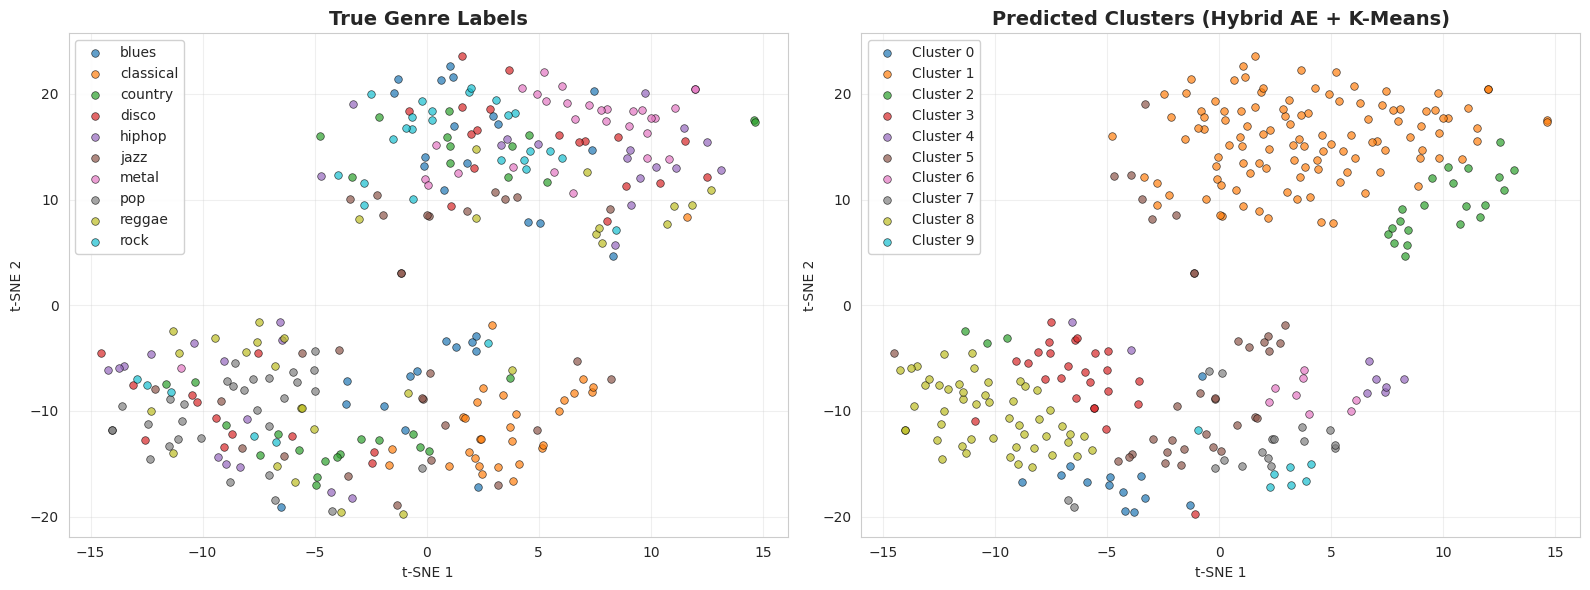

Saved: tsne_visualization.png


In [13]:
# t-SNE visualization
print('Generating t-SNE visualization...')

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(hybrid_ae_features)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# True labels
for i, genre in enumerate(GENRES):
    mask = y == i
    axes[0].scatter(tsne_features[mask, 0], tsne_features[mask, 1],
                   c=[colors[i]], label=genre, alpha=0.7, s=30, edgecolors='black', linewidth=0.5)

axes[0].set_title('True Genre Labels', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', framealpha=0.9)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')

# Predicted clusters (best method)
for i in range(N_CLUSTERS):
    mask = km_hybrid_ae == i
    axes[1].scatter(tsne_features[mask, 0], tsne_features[mask, 1],
                   c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=30, edgecolors='black', linewidth=0.5)

axes[1].set_title('Predicted Clusters (Hybrid AE + K-Means)', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', framealpha=0.9)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print('Saved: tsne_visualization.png')

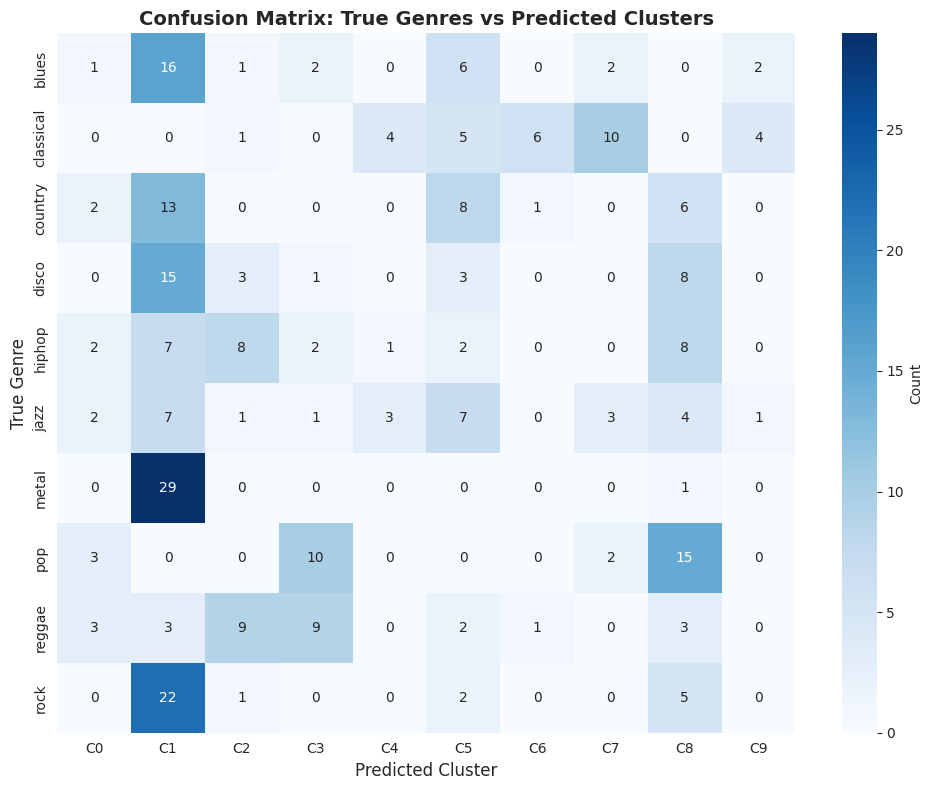

Saved: confusion_matrix.png


In [14]:
# Confusion matrix (best method)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, km_hybrid_ae)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'C{i}' for i in range(N_CLUSTERS)],
            yticklabels=GENRES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix: True Genres vs Predicted Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Cluster', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print('Saved: confusion_matrix.png')

## 7. Summary

In [1]:
print('\n' + '='*100)
print('MEDIUM TASK COMPLETE!')
print('='*100)

print('\nWhat was implemented:')
print('  - Audio feature extraction (MFCC)')
print('  - Lyrics embeddings (multi-modal)')
print('  - Neural network autoencoder')
print('  - Hybrid audio+lyrics features')
print('  - 5 clustering methods')
print('  - 5 evaluation metrics')

print('\nBest performing method:')
best_idx = df_results['Silhouette'].idxmax()
best = df_results.iloc[best_idx]
print(f'  {best["Method"]}')
print(f'  Silhouette Score: {best["Silhouette"]:.4f}')
print(f'  ARI: {best["ARI"]:.4f}')
print(f'  NMI: {best["NMI"]:.4f}')

print('\nFiles created:')
print('  - medium_results.csv')
print('  - metrics_comparison.png')
print('  - tsne_visualization.png')
print('  - confusion_matrix.png')

print('\n' + '='*100)

print('='*100)


MEDIUM TASK COMPLETE!

What was implemented:
  - Audio feature extraction (MFCC)
  - Lyrics embeddings (multi-modal)
  - Neural network autoencoder
  - Hybrid audio+lyrics features
  - 5 clustering methods
  - 5 evaluation metrics

Best performing method:


NameError: name 'df_results' is not defined